In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from core.rejection_stem import simulate, Channel
#from scipy.stats import lognorm, expon, gengamma
from scipy.special import gamma
from scipy.stats import weibull_min
from reliability.Fitters import Fit_Weibull_2P
import ot

# local imports
from utils.plot import *
from utils.helper import *

%load_ext autoreload
%autoreload 2

# Add 3rd term in Taylor expansion and record error for $\Delta t$


## Simulate using 1st order approximation

In [ ]:
# samples for bootstrapping
bs_raw = pd.read_csv('./data/bootstraps10.csv')
bs_avg = calculate_bs_avg(bs_raw)

# Define simulation parameters R1
r0_esc = 0.032171966842843534
r0_epi = 0.016751863648585066
alpha_esc = 3.41100504926811
alpha_epi = 3.613655856845829


channels = {
        'esc' : Channel('esc', r0=r0_esc, alpha=alpha_esc),
        'epi' : Channel('epi', r0=r0_epi, alpha=alpha_epi)
    }
t_end = 350
n_esc = 1000
n_sim = 10
timepoints = 350

# Run simulation R1
population_r1, channels_out_r1, t2_error = simulate(t_end, n_sim, timepoints, channels, n_esc=n_esc, order_approx=1, verbose=False)
# Convert simulation np.array to pd.DataFrame, long format
# The function also normalises the simulation using L1 norm
pop_long_r1 = arr_to_df(population_r1, t_end, scaler=None, long=True)

# Plot simulation vs experimental
plot_sim_vs_exp(pop_long_r1, bs_raw, cell_line='R1' ,filepath='./figures/sim_vs_exp.png')

# Plot simulation only
plot_population(population_r1, t_end, filepath=None)
# Plot wait-time distributions
plot_event_dist(channels_out_r1,t_end, filepath=None)
# RMSE
pop_r1 = arr_to_df(population_r1, t_end, scaler=None, long=False)
bs_r1 = bs_to_wide(bs_avg, cell_line = 'R1')
rmse = calculate_rmse(bs_r1, pop_r1)

## Simulate using 2nd order approximation

In [ ]:
# samples for bootstrapping
bs_raw = pd.read_csv('./data/bootstraps10.csv')
bs_avg = calculate_bs_avg(bs_raw)

# Define simulation parameters R1
r0_esc = 0.032171966842843534
r0_epi = 0.016751863648585066
alpha_esc = 3.41100504926811
alpha_epi = 3.613655856845829

channels = {
        'esc' : Channel('esc', r0=r0_esc, alpha=alpha_esc),
        'epi' : Channel('epi', r0=r0_epi, alpha=alpha_epi)
    }
t_end = 350
n_esc = 1000
n_sim = 10
timepoints = 350

# Run simulation R1
population_r1, channels_out_r1, t2_error = simulate(t_end, n_sim, timepoints, channels, n_esc=n_esc, order_approx=2, verbose=False)
# Convert simulation np.array to pd.DataFrame, long format
# The function also normalises the simulation using L1 norm
pop_long_r1 = arr_to_df(population_r1, t_end, scaler=None, long=True)

# Plot simulation vs experimental
plot_sim_vs_exp(pop_long_r1, bs_raw, cell_line='R1' ,filepath=None)

# Plot simulation only
plot_population(population_r1, t_end, filepath=None)
# Plot wait-time distributions
plot_event_dist(channels_out_r1,t_end, filepath=None)
# RMSE
pop_r1 = arr_to_df(population_r1, t_end, scaler=None, long=False)
bs_r1 = bs_to_wide(bs_avg, cell_line = 'R1')
rmse = calculate_rmse(bs_r1, pop_r1)

# Run simulations over increasing initial population sizes (log space of n_start) and record EMD

## For 1st order approx

In [ ]:
# samples for bootstrapping
bs_raw = pd.read_csv('./data/bootstraps10.csv')
bs_avg = calculate_bs_avg(bs_raw)

# Define simulation parameters R1
r0_esc = 0.032171966842843534
r0_epi = 0.016751863648585066
alpha_esc = 3.41100504926811
alpha_epi = 3.613655856845829

channels = {
        'esc' : Channel('esc', r0=r0_esc, alpha=alpha_esc),
        'epi' : Channel('epi', r0=r0_epi, alpha=alpha_epi)
    }
t_end = 350
n_sim = 50
timepoints = 350

emd_dict_t1 = {'esc':[], 'epi':[]}

n_ls = np.logspace(0, 7, num=8, base=np.e)
n_ls = np.around(n_ls)
n_ls = n_ls.astype(int)

for i,n in enumerate(n_ls):
    print('{}: Initial population size of: {}'.format(i+1, n))
    population_r1, channels_out_r1, t2_error = simulate(t_end, n_sim, timepoints, channels, n_esc=n, order_approx=1, verbose=False)
    for k in channels_out_r1:
        wt = channels_out_r1[k].wait_times
        alpha = channels_out_r1[k].alpha
        r0 = channels_out_r1[k].r0
        emd = calculate_emd_avg(wt, alpha, r0)
        emd_dict_t1[k].append(emd)

## Run for 2nd order approx

In [ ]:
# samples for bootstrapping
bs_raw = pd.read_csv('./data/bootstraps10.csv')
bs_avg = calculate_bs_avg(bs_raw)

# Define simulation parameters R1
r0_esc = 0.032171966842843534
r0_epi = 0.016751863648585066
alpha_esc = 3.41100504926811
alpha_epi = 3.613655856845829

channels = {
        'esc' : Channel('esc', r0=r0_esc, alpha=alpha_esc),
        'epi' : Channel('epi', r0=r0_epi, alpha=alpha_epi)
    }
t_end = 350
n_sim = 50
timepoints = 350

emd_dict_t2 = {'esc':[], 'epi':[]}

n_ls = np.logspace(0, 7, num=8, base=np.e)
n_ls = np.around(n_ls)
n_ls = n_ls.astype(int)
for i,n in enumerate(n_ls):
    print('{}: Initial population size of: {}'.format(i+1, n))
    population_r1, channels_out_r1, t2_error = simulate(t_end, n_sim, timepoints, channels, n_esc=n, order_approx=2, verbose=False)
    for k in channels_out_r1:
        wt = channels_out_r1[k].wait_times
        alpha = channels_out_r1[k].alpha
        r0 = channels_out_r1[k].r0
        emd = calculate_emd_avg(wt, alpha, r0)
        emd_dict_t2[k].append(emd)

### Save results

In [ ]:
emd_dict_t1['n'] = n_ls
emd_dict_t2['n'] = n_ls
df_emd_t1 = pd.DataFrame(emd_dict_t1)
df_emd_t2 = pd.DataFrame(emd_dict_t2)
df_emd_t1.to_csv('./taylor/emd_t1_log_50sim.csv', index=False)
df_emd_t2.to_csv('./taylor/emd_t2_log_50sim.csv', index=False)

In [ ]:
# load results
df_t1 = pd.read_csv('./taylor/emd_t1_log_50sim.csv', index_col=None)
emd_dict_t1 = df_t1

df_t2 = pd.read_csv('./taylor/emd_t2_log_50sim.csv', index_col=None)
emd_dict_t2 = df_t2
n_ls = emd_dict_t2['n']

### Plot results

In [ ]:
plot_dt_error(n_ls, emd_dict_t1, emd_dict_t2, cell_type='esc', filepath=None)

In [ ]:
plot_dt_error(n_ls, emd_dict_t1, emd_dict_t2, cell_type='epi', filepath=None)

In [ ]:
np.array(channels['esc'].wait_times).shape

## Scale up to 500 simulations
Simulation ran separately on cluster

### Load data

In [2]:
df_t1 = pd.read_csv('./taylor/emd_t1_log_500sim.csv', index_col=None)
emd_dict_t1 = df_t1
df_t2 = pd.read_csv('./taylor/emd_t2_log_500sim.csv', index_col=None)
emd_dict_t2 = df_t2
n_ls = emd_dict_t2['n']

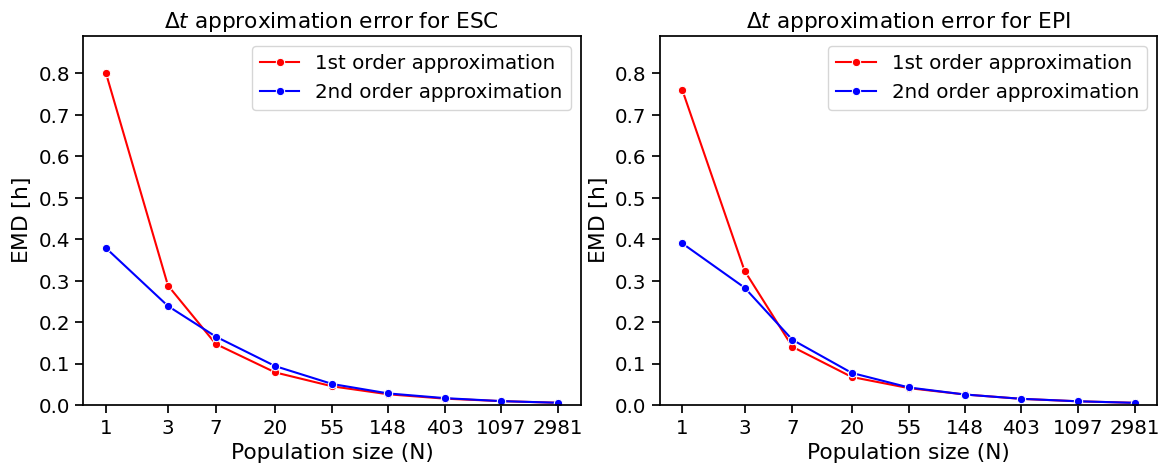

In [3]:
plot_dt_error_both(n_ls, emd_dict_t1, emd_dict_t2, filepath='./figures/taylor_500.png')